In [1]:
run import_packages.ipynb

success


# Section 1. Classic EPR model

In [9]:
def Explore_location(lat,lon,d,brng):
    '''
    :param lat,lon: current locations' lat and lon
    :papra d: move distance
    :para brng: move angle
    return locations' lat,lon
    '''
    R = 6378.1  # Radius of the Earth
    lat1 = math.radians(lat)  # Current lat point converted to radians
    lon1 = math.radians(lon)  # Current long point converted to radians

    lat2 = math.asin(math.sin(lat1) * math.cos(d / R) +
                     math.cos(lat1) * math.sin(d / R) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d / R) * math.cos(lat1),
                             math.cos(d / R) - math.sin(lat1) * math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)
    return lat2,lon2

def return_location(S,prob):
    '''
    :param S: visited locations
    :papra prob: locations' probablity
    return locations' lat,lon,index
    '''
    index=-1
    temp = np.random.rand()
    for i in range(len(prob)-1):
        if temp>prob[i] and temp<=prob[i+1]:
            index=i
            break
    if index==-1:
        index=len(prob)-1
    (lat,lon)=list(S.keys())[index]
    return lat,lon,index

def genrate_random_power_laws(alpha,num):
    '''
    :param alpha: exponent of power law
    :papra num: number of random values
    return random values 
    '''
    x=[ i for i in range(1,10000)]
    prob=[math.pow(i,alpha) for i in x]
    return random.choices(np.asarray(x), np.asarray(prob),k=num)


def distance_compute(lat1,lon1,lat2,lon2):
    '''
    :param lat1: latitude for first location
    :param lon1: longitude for first location
    :param lat2: latitude for second location
    :param lat2: longitude for second location
    return distance
    '''
    dL = lon2 - lon1
    X = math.cos(lat2) * math.sin(dL)
    Y =math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dL)
    bearing = np.arctan2(X, Y)
    bearing = np.degrees(bearing)

    R = 6373.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) *math. cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c

    return d



def Exploration_Preferentail_return(alpha, beta, rho,gamma,num_steps,num_indi,case):
    """
    :param alpha: exponent for stay duration
    :param beta: exponent for distance
    :param rho: explore para
    :param gamma: exponent for visited locations
    :param home_lat: initial lat
    :param home_lon: initial lon
    :param timestep: simualiton steps
    :param str_individual: individual
    :return: individual trajectory dataframe
    """
    df=pd.DataFrame(columns=['id','step','explore','P_new','label','lat','lon','stay_t','r_next','angle_next','distance_home'])
    for indi in range(0,num_indi):
        #print('indi',indi)
        home_lat=random.uniform(-20, -20)
        home_lon=random.uniform(-20, -20)
        
        delta_t=genrate_random_power_laws(alpha,num_steps)
        delta_r =genrate_random_power_laws(beta,num_steps)
        delta_angle = np.random.uniform(-180,180,num_steps)
        S=dict()
        S[(home_lat,home_lon)]=1
        current_location=(home_lat,home_lon)
        current_index=0
        for step in range(0,num_steps):
            #print(step)
            temp = np.random.rand()
            if case=='pow_S':
                P_new=rho*math.pow(len(S),gamma)
            if case=='normal_S':
                P_new=-1
                while P_new<0:
                    P_new=np.random.normal(0.5, 0.5, 1)
            if case=='condition':
                P_new=len(df[(df['step']>=step-50)&(df['explore']=='return')])/(len(df[(df['step']>=step-50)])+1)
            ###Explore
            if temp<P_new:
                new_lat, new_lon=Explore_location(current_location[0],current_location[1],delta_r[step],delta_angle[step])
                S[(new_lat, new_lon)]=1
                index=len(S)-1
                keyword='explore'
            ###Return
            else:
                temp_list=list(S.values())
                prob=np.cumsum(list(map(lambda x: x/np.sum(temp_list), temp_list)))
                new_lat, new_lon,index=return_location(S, prob)
                S[(new_lat, new_lon)] += 1
                keyword = 'return'

            distance_home=distance_compute(current_location[0],current_location[1],home_lat,home_lon)
            df.loc[step]=[str(indi),step,keyword,P_new,current_index,current_location[0],current_location[1],delta_t[step],delta_r[step],delta_angle[step],distance_home]
            current_location = (new_lat, new_lon)
            current_index=index
    stroutput="alpha"+str(alpha)+"beta"+str(beta)+"rho"+str(rho)+"gamma"+str(gamma)+case
    print(stroutput)
    df.to_csv('EPR_model/generated_trajecotry'+stroutput+'.csv')
    
    

    

In [26]:
######testing classic EPR model
####alpha: the exponent of travel distance
####beta: the exponent of travel time
####rho: the associated para for new exploration
###gamma: the associated para for new exploration
###steps: simualtion steps
###num_indi: simulaiton individuals

[alpha, beta, rho, gamma, steps,num_indi]=[-1,-1,0.1,-0.5,10000,1]

for alpha in [-1,-1.5, -2]:
    for beta in [-1, -1.5,-2]:
        for case in ['pow_S','normal_S','condition']:
            print('testing---------')
            print('alpha is', alpha,';beta is',beta,';exploration case is',case)
            Exploration_Preferentail_return(alpha, beta, rho, gamma, steps, num_indi, case)
            print('testing finished---------')

            

testing---------
alpha is -1 ;beta is -1 ;exploration case is pow_S
indi 0
alpha-1beta-1rho0.1gamma-0.5pow_S
testing finished---------
testing---------
alpha is -1 ;beta is -1 ;exploration case is normal_S
indi 0
alpha-1beta-1rho0.1gamma-0.5normal_S
testing finished---------
testing---------
alpha is -1 ;beta is -1 ;exploration case is condition
indi 0
alpha-1beta-1rho0.1gamma-0.5condition
testing finished---------
testing---------
alpha is -1 ;beta is -1.5 ;exploration case is pow_S
indi 0
alpha-1beta-1.5rho0.1gamma-0.5pow_S
testing finished---------
testing---------
alpha is -1 ;beta is -1.5 ;exploration case is normal_S
indi 0
alpha-1beta-1.5rho0.1gamma-0.5normal_S
testing finished---------
testing---------
alpha is -1 ;beta is -1.5 ;exploration case is condition
indi 0
alpha-1beta-1.5rho0.1gamma-0.5condition
testing finished---------
testing---------
alpha is -1 ;beta is -2 ;exploration case is pow_S
indi 0
alpha-1beta-2rho0.1gamma-0.5pow_S
testing finished---------
testing--------

KeyboardInterrupt: 

In [27]:
#######Results plot

def linear_function(x, a, b):
	return a * np.asarray(x)+b

def fitting(x,y):
    '''
    :param x: given x
    :param y: given y
    return learned functions param (a,b) and estiamted x and y
    '''
    popt, _ = curve_fit(linear_function, np.log10(np.asarray(x)+0.000001),np.log10(np.asarray(y)+0.00001),maxfev=10000)
    a,b=popt
    x_line = np.asarray(x)+0.000001
    # calculate the output for the range
    y_line = linear_function(np.log10(x_line), a, b)
    y_line=[np.power(10,i) for i in y_line]
    return a,b,x_line, y_line


def S_frequency_plot(alpha, beta, rho, gamma):
    '''
    :param alpha, beta, rho,gamma: params to find the saved csv data
    return figures 1 about visited locations S(t)
           figures 2 about frequency of visited locations
    '''
    stroutput = "alpha" + str(alpha) + "beta" + str(beta) + "rho" + str(rho) + "gamma" + str(gamma) + 'pow_S'
    df_pow=pd.read_csv('EPR_model/generated_trajecotry' + stroutput + '.csv')

    stroutput = "alpha" + str(alpha) + "beta" + str(beta) + "rho" + str(rho) + "gamma" + str(gamma) + 'normal_S'
    df_normal = pd.read_csv('EPR_model/generated_trajecotry' + stroutput + '.csv')

    stroutput = "alpha" + str(alpha) + "beta" + str(beta) + "rho" + str(rho) + "gamma" + str(gamma) + 'condition'
    df_condition= pd.read_csv('EPR_model/generated_trajecotry' + stroutput + '.csv')
    
    stroutput = "alpha" + str(alpha) + "beta" + str(beta) + "rho" + str(rho) + "gamma" + str(gamma)
    
    print('plotting S(t)--------------')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    for df,ax,label in zip([df_pow,df_normal,df_condition],[ax1,ax2,ax3],[r'$\rho t^{\gamma}$',r'$N(0.5,0.5)$',r'f_{return}/f_{all}']):
        dict_label = Counter(df['label'])
        df_temp = df[df['label'] !=0]
        df_temp = df_temp.drop_duplicates(subset=['label'])
        df_temp['t_cum'] =np.cumsum(df_temp['stay_t'])
        df_temp['s_cum']=np.cumsum([1 for i in range(len(df_temp))])

        ax.scatter(df_temp['t_cum'], df_temp['s_cum'], s=5, color='blue', alpha=0.2,label=label)
        a1, b1, xline, yline = fitting(df_temp['t_cum'], df_temp['s_cum'])
        ax.scatter(xline, yline, color='grey', linewidth=1, alpha=0.5, s=1)
        ax.text(1.2, 1.2, 'slope=%f' % (a1))

        ax.set_xlabel('t(h)')
        ax.set_ylabel('S(t)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(stroutput)
        ax.set_ylim(1,df_temp['s_cum'].max()*1.1)
        ax.set_xlim(1, df_temp['t_cum'].max()*1.1)
        ax.legend()
    fig.savefig('EPR_model/EPR_results_explore'+stroutput+'.png', dpi=600)
    
    print('plotting frequency--------------')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    for df, ax, label in zip([df_pow, df_normal, df_condition], [ax1, ax2, ax3],
                             [r'$\rho t^{\gamma}$', r'$N(0.5,0.5)$', r'f_{return}/f_{all}']):
        dict_label = Counter(df['label'])
        df_temp = df[df['label'] !=0]
        df_temp = df_temp.drop_duplicates(subset=['label'])
        df_temp['frequency'] = list(map(lambda x: dict_label[x], df_temp['label']))
        df_temp = df_temp.groupby(['distance_home'])['frequency'].mean().reset_index()
        frequency = []
        distance_list = list([i for i in range(0, 10)]) + list([i * 10 for i in range(1, 200)])
        for dis in distance_list:
            if dis < 10:
                ad = 1
            else:
                ad = 10
            frequency.append( df_temp[(df_temp['distance_home'] <= (dis + ad)) & (df_temp['distance_home'] > dis)][
                    'frequency'].sum())

        ax.scatter(distance_list,frequency, s=5, color='blue', label=label)
        ax.axvline(x=10)
        ax.set_xlabel('distance from home')
        ax.set_ylabel('frequency')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(stroutput)
        ax.set_ylim(1, np.max(distance_list) * 1.1)
        ax.set_xlim(0,np.max(frequency) * 1.1)
        ax.legend()
    fig.savefig('EPR_model/EPR_results_frequency'+stroutput+'.png', dpi=600)
    


plotting S(t)--------------
plotting frequency--------------


/Users/lucinezhong/.conda/envs/PDE-COVID/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



plotting S(t)--------------
plotting frequency--------------
plotting S(t)--------------
plotting frequency--------------
plotting S(t)--------------
plotting frequency--------------


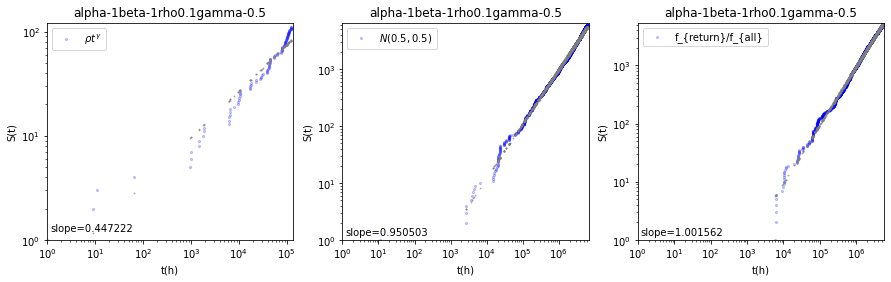

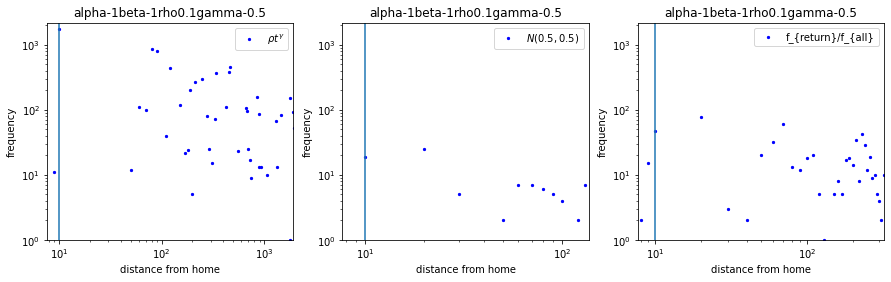

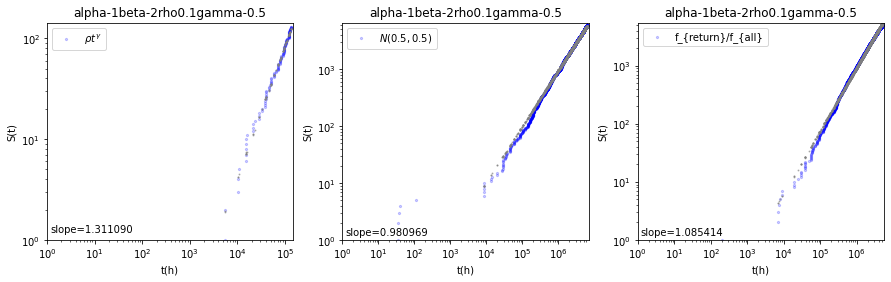

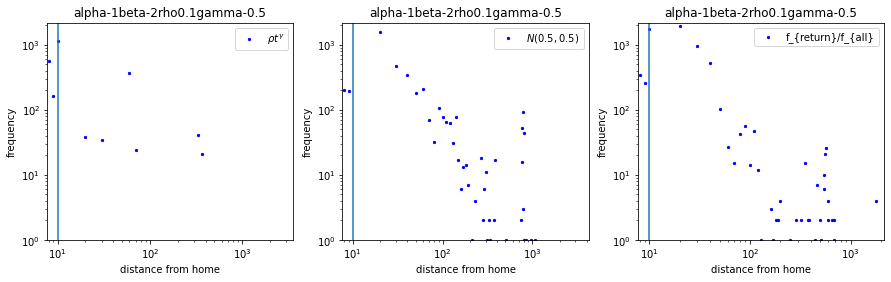

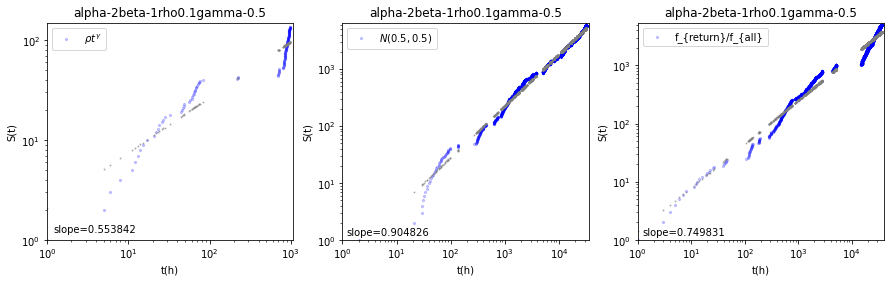

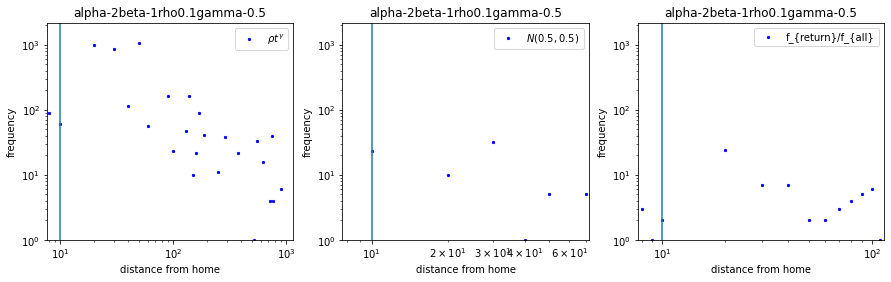

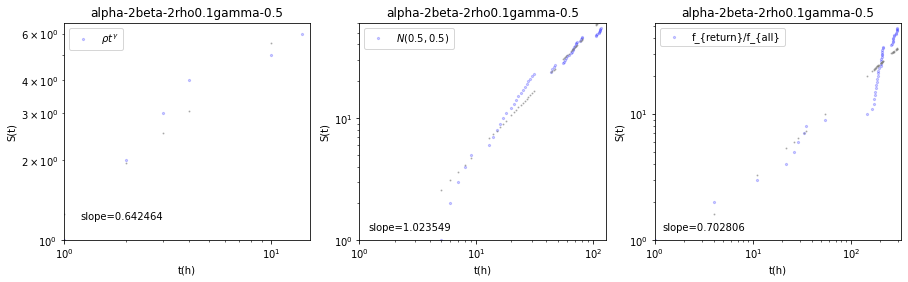

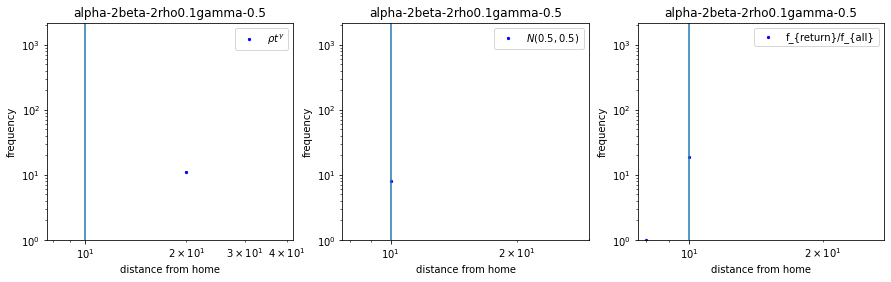

In [28]:
for alpha in [-1,-2]:
    for beta in [-1,-2]:
        
        S_frequency_plot(alpha, beta, rho, gamma)
        

# Seciton 2. EPR model--Time considered

In [ ]:
########A test if each time interval is influenced by global informaiton
import pickle

class UserInfo:
    def __init__(self, id_num, home_lat,home_lon,alpha,num_steps):
      self.id = id_num
      self.home=(home_lat,home_lon)
      self.current_loc=(home_lat,home_lon)
      self.current_loc_label=0
      self.current_t=0
      self.S=dict() ######visited locations and their frequency
      self.delta_t=[] ######stay duration 
      self.delta_r=[] #####travel distance
      self.delta_a=[]####travel angle
      self.preference=np.random.rand() ######stickness to self
      
    

def EPR_each(User,Global_S):
    '''
    Classic EPR model
    '''
    temp = np.random.rand()
    P_new=rho*math.pow(len(User.S),gamma)
    ###Explore
    if temp<P_new:
        new_lat, new_lon=Explore_location(User.current_loc[0],User.current_loc[1],User.delta_r[0],User.delta_a[0])
        User.S[(new_lat, new_lon)]=1
        User.current_loc=(new_lat, new_lon)
        index=len(User.S)-1
        User.current_loc_label=index
        User.current_t+=User.delta_t[0]
        ######saving global info
        Global_S[(new_lat, new_lon)]=dict()
        Global_S[(new_lat, new_lon)]['f']=1
        Global_S[(new_lat, new_lon)]['t']=[User.delta_t[0]]
        keyword='Explore'
    ###Return
    else:
        temp_list=list(User.S.values())
        prob=np.cumsum(list(map(lambda x: x/np.sum(temp_list), temp_list)))
        new_lat, new_lon,index=return_location(User.S, prob)
        User.current_loc=(new_lat, new_lon)
        User.S[(new_lat, new_lon)] += 1
        User.current_t+=User.delta_t[0]
        User.current_loc_label=index
        ######saving global info
        if (new_lat, new_lon)!=User.home:
            Global_S[(new_lat, new_lon)]['f']+=1
            Global_S[(new_lat, new_lon)]['t'].append(User.delta_t[0])
        keyword='Return'
    return P_new, index,new_lat, new_lon,User.delta_t[0],keyword
        
def find_location(S,prob):
    '''
    :param S: visited locations
    :papra prob: locations' probablity
    return locations' lat,lon,index
    '''
    index=-1
    temp = np.random.rand()
    for i in range(len(prob)-1):
        if temp>prob[i] and temp<=prob[i+1]:
            index=i
            break
    if index==-1:
        index=len(prob)-1
    (lat,lon)=list(S.keys())[index]
    return lat,lon,index

       
def Explore_location_global(lat,lon,d,brng,Global_S,User):
    '''
    :param lat,lon: current locations' lat and lon
    :papra d: move distance
    :para brng: move angle
    return locations' lat,lon
    '''
    temp = np.random.rand()
    if temp<User.preference:
        R = 6378.1  # Radius of the Earth
        lat1 = math.radians(lat)  # Current lat point converted to radians
        lon1 = math.radians(lon)  # Current long point converted to radians

        lat2 = math.asin(math.sin(lat1) * math.cos(d / R) +
                         math.cos(lat1) * math.sin(d / R) * math.cos(brng))

        lon2 = lon1 + math.atan2(math.sin(brng) * math.sin(d / R) * math.cos(lat1),
                                 math.cos(d / R) - math.sin(lat1) * math.sin(lat2))

        lat2 = math.degrees(lat2)
        lon2 = math.degrees(lon2)
        stay_t=User.delta_t[0]
    else:
        Global_S_copy=copy.deepcopy(Global_S)
        for key in User.S.keys():
            if key in Global_S.keys():
                Global_S_copy.pop(key)
        sum_temp=np.sum([v['f'] for v in Global_S_copy.values()])
        prob=[v['f']/sum_temp for v in Global_S_copy.values()]
        lat2,lon2,index=find_location(Global_S_copy,prob)
        #####adjusting stay duration with individual's preference and global preference
        stay_t1=np.mean(Global_S[(lat2,lon2)]['t'])
        stay_t2=User.delta_t[0]
        stay_t=stay_t1*(1-User.preference)+stay_t2*(User.preference)
    return lat2,lon2,stay_t

              
def EPR_global(User,Global_S,ave_S):
    '''
    Modified EPR model with globa infor
    :param User: indivdual user 
    :param Global_S: global visited locations and frequency
    :ave_S: global averaged visited locations
    return updated User, updated Global_S
    '''
    
    temp = np.random.rand()
    #####adjusting P_new with individual's incentive and global incentive
    P_new=rho*math.pow(len(User.S),gamma)
    P_global=rho*math.pow(ave_S,gamma)
    P_new=P_new*User.preference+P_global*(1-User.preference)
    
    ###Explore
    if temp<P_new:
        new_lat,new_lon,stay_t=Explore_location_global(User.current_loc[0],User.current_loc[1],User.delta_r[0],User.delta_a[0],Global_S,User)
        User.S[(new_lat, new_lon)]=1
        User.current_loc=(new_lat, new_lon)
        index=len(User.S)-1
        User.current_loc_label=index
        ######saving global info
        Global_S[(new_lat, new_lon)]=dict()
        Global_S[(new_lat, new_lon)]['f']=1
        Global_S[(new_lat, new_lon)]['t']=[stay_t]
        User.current_t+=stay_t
        keyword='Explore'
    ###Return
    else:
        temp_list=list(User.S.values())
        prob=np.cumsum(list(map(lambda x: x/np.sum(temp_list), temp_list)))
        new_lat, new_lon,index=find_location(User.S, prob)
        User.current_loc=(new_lat, new_lon)
        User.S[(new_lat, new_lon)] += 1
        #####adjusting stay duration with individual's preference and global preference
        if (new_lat,new_lon) in Global_S.keys():
            stay_t1=np.mean(Global_S[(new_lat,new_lon)]['t'])
            stay_t2=User.delta_t[0]
            stay_t=stay_t1*(1-User.preference)+stay_t2*(User.preference)
        else:
            stay_t=User.delta_t[0]
        User.current_t+=stay_t
        User.current_loc_label=index
        ######saving global info
        if (new_lat, new_lon)!=User.home:
            Global_S[(new_lat, new_lon)]['f']+=1
            Global_S[(new_lat, new_lon)]['t'].append(User.delta_t[0])
        keyword='Return'
    return P_new, index,new_lat, new_lon,stay_t,keyword
        
def Exploration_Preferentail_return_time_global(alpha, beta, rho,gamma,num_steps,num_indi,case):
    """
    :param alpha: exponent for distance
    :param beta: exponent for stay duration
    :param rho: explore para
    :param gamma: exponent for visited locations
    :param home_lat: initial lat
    :param home_lon: initial lon
    :param timestep: simualiton steps
    :param str_individual: individual
    :return: individual trajectory dataframe
    """
    
    df=pd.DataFrame(columns=['id','step','t','keyword','P_new','label','lat','lon','stay_t','distance_home'])
    

    Global_S=defaultdict()#####save the global info for locaitons' visited frequency and duration
    time_interval=1 ####here could be any minutes
    
    ######initialize
    indiStatus = {}
    for indi in range(0,num_indi):
        home_lat=random.uniform(-20, 20)
        home_lon=random.uniform(-20, 20)
        indiStatus[indi]=UserInfo(indi, home_lat,home_lon,alpha,num_steps)
        indiStatus[indi].S[(home_lat,home_lon)]=1
        indiStatus[indi].delta_t=genrate_random_power_laws(alpha,num_steps)
        indiStatus[indi].delta_r=genrate_random_power_laws(beta,num_steps)
        indiStatus[indi].delta_a=np.random.uniform(-180,180,num_steps)
        
    ####begin simulaiton
    ####simulation ends at time acculate to num_steps*time_interval
    for step in range(0,num_steps):
        print('step',step,len(Global_S))
        for indi in range(num_indi):
            if len(Global_S)<30: ######less than xxx new locations is explored
                ######come into case only consider local info
                if step*time_interval==int(indiStatus[indi].current_t):
                    P_new, index,new_lat, new_lon,stay_t,keyword=EPR_each(indiStatus[indi],Global_S)
                    indiStatus[indi].delta_t=np.delete(indiStatus[indi].delta_t,0)
                    indiStatus[indi].delta_r=np.delete(indiStatus[indi].delta_r,0)
                    indiStatus[indi].delta_a=np.delete(indiStatus[indi].delta_a,0)
                    print('step_classic',step,'inidi',indi, keyword, indiStatus[indi].current_t,P_new, index,new_lat, new_lon,stay_t)
                            
            else:
                ######come into case both codiser loacl and global info
                ####global average S
                ave_S=np.mean([len(indiStatus[indi].S) for indi in range(0,num_indi)])
                if step*time_interval==int(indiStatus[indi].current_t):
                    P_new, index,new_lat, new_lon,stay_t,keyword=EPR_global(indiStatus[indi],Global_S,ave_S)
                    indiStatus[indi].delta_t=np.delete(indiStatus[indi].delta_t,0)
                    print('step_global',step,'inidi',indi,keyword, indiStatus[indi].current_t,P_new, index,new_lat, new_lon,stay_t)
            
            distance_home=distance_compute(indiStatus[indi].home[0],indiStatus[indi].home[1],new_lat,new_lon)
            df.loc[step]=[str(indi),step,step*time_interval,keyword, P_new, index,new_lat, new_lon,stay_t,distance_home]           
            
    stroutput="alpha"+str(alpha)+"beta"+str(beta)+"rho"+str(rho)+"gamma"+str(gamma)+case
    print(stroutput)
    df.to_csv('EPR_model/generated_trajecotry'+stroutput+'.csv')
    
    with open('EPR_model/Global_S.pickle', 'wb') as handle:
        pickle.dump(Global_S, handle, protocol=pickle.HIGHEST_PROTOCOL)                                               
                                                   
######testing 
print('---------start testing EPR model with global info----------')
[alpha, beta, rho, gamma, num_steps,num_indi]=[-1,-2,0.1,-0.5,10000,100]
print('alpha is %f, beta is %f, rho is %f, gamma is %f, steps is %s, num_indi is %s' %(alpha, beta, rho, gamma, num_steps,num_indi))

Exploration_Preferentail_return_time_global(alpha, beta, rho,gamma,num_steps,num_indi,case)

print('---------end testing EPR model with global info----------')

---------start testing EPR model with global info----------
alpha is -1.000000, beta is -2.000000, rho is 0.100000, gamma is -0.500000, steps is 10000, num_indi is 100
step 0 0
step_classic 0 inidi 0 Return 6 0.1 0 -19.48421814151818 13.893403350776325 6
step_classic 0 inidi 1 Return 1 0.1 0 0.12601004988001208 -9.1115740007529 1
step_classic 0 inidi 2 Return 174 0.1 0 14.161448050558072 2.290874373059747 174
step_classic 0 inidi 3 Return 1 0.1 0 -19.51245116234475 14.454958807141473 1
step_classic 0 inidi 4 Return 192 0.1 0 -2.61859449143353 14.089555348299967 192
step_classic 0 inidi 5 Return 102 0.1 0 14.273147685841266 -0.440918199766255 102
step_classic 0 inidi 6 Return 5 0.1 0 -4.197702374097849 4.744209881102041 5
step_classic 0 inidi 7 Return 148 0.1 0 6.712366270934879 -18.466563033645688 148
step_classic 0 inidi 8 Explore 3629 0.1 1 18.979000802589237 4.4484109969917665 3629
step_classic 0 inidi 9 Return 1 0.1 0 16.616556709114285 16.156605668344767 1
step_classic 0 inidi 10 

step_classic 1 inidi 35 Return 4 0.1 0 3.8091603923263477 -13.543306649755994 3
step_classic 1 inidi 40 Return 3 0.1 0 -13.45541297727696 18.06937848246465 2
step_classic 1 inidi 42 Return 4198 0.1 0 5.096956933197788 -5.65633632835198 4197
step_classic 1 inidi 58 Return 7 0.1 0 -9.821969378944662 10.473001576791763 6
step_classic 1 inidi 64 Return 43 0.1 0 -8.808994689182676 -13.77471653888383 42
step_classic 1 inidi 70 Return 1743 0.1 0 -1.3052882852784329 5.508394671558015 1742
step_classic 1 inidi 75 Return 1280 0.1 0 10.055622678173801 -9.678467692519908 1279
step_classic 1 inidi 78 Return 2 0.1 0 13.883939042008087 -7.882863978467508 1
step 2 9
step_classic 2 inidi 1 Return 6 0.1 0 0.12601004988001208 -9.1115740007529 4
step_classic 2 inidi 36 Return 296 0.1 0 -16.42950792784354 -8.97478234449341 294
step_classic 2 inidi 38 Explore 4 0.1 1 5.297923933467955 -14.654284561836583 2
step_classic 2 inidi 57 Return 36 0.07071067811865477 0 -5.287558285020717 18.487999798221708 34
step_

step 55 16
step 56 16
step 57 16
step 58 16
step 59 16
step 60 16
step_classic 60 inidi 24 Return 87 0.1 0 -12.309308739713716 13.615451309252606 27
step 61 16
step 62 16
step 63 16
step 64 16
step 65 16
step_classic 65 inidi 29 Return 5883 0.1 0 -2.7033496719250394 17.45239866746821 5818
step 66 16
step 67 16
step_classic 67 inidi 53 Return 68 0.1 0 -17.88254376425042 8.092606792715848 1
step 68 16
step_classic 68 inidi 53 Return 70 0.1 0 -17.88254376425042 8.092606792715848 2
step 69 16
step_classic 69 inidi 76 Return 3231 0.1 0 2.223898226006959 19.847643742442983 3162
step 70 16
step_classic 70 inidi 53 Return 78 0.1 0 -17.88254376425042 8.092606792715848 8
step_classic 70 inidi 90 Return 100 0.1 0 -2.3759551220778654 17.32479326433753 30
step 71 16
step 72 16
step 73 16
step 74 16
step 75 16
step 76 16
step 77 16
step 78 16
step_classic 78 inidi 53 Return 85 0.1 0 -17.88254376425042 8.092606792715848 7
step 79 16
step 80 16
step 81 16
step_classic 81 inidi 23 Explore 88 0.1 1 11.4

step 288 24
step 289 24
step 290 24
step 291 24
step 292 24
step 293 24
step 294 24
step 295 24
step 296 24
step_classic 296 inidi 36 Return 362 0.1 0 -16.42950792784354 -8.97478234449341 66
step 297 24
step_classic 297 inidi 23 Return 753 0.07071067811865477 1 11.40498990337519 10.511815055792274 456
step_classic 297 inidi 24 Return 1524 0.1 0 -12.309308739713716 13.615451309252606 1227
step 298 24
step 299 24
step 300 24
step 301 24
step 302 24
step 303 24
step_classic 303 inidi 12 Return 9662 0.057735026918962574 2 6.661226603723666 -5.8540302663877295 9359
step 304 24
step 305 24
step 306 24
step 307 24
step_classic 307 inidi 86 Explore 324 0.1 1 12.98487818356973 7.506678578250202 17
step 308 25
step 309 25
step 310 25
step 311 25
step 312 25
step 313 25
step 314 25
step 315 25
step 316 25
step 317 25
step 318 25
step 319 25
step 320 25
step 321 25
step 322 25
step 323 25
step 324 25
step_classic 324 inidi 86 Return 345 0.07071067811865477 0 12.99198455819019 7.50103907713083 21
s

step 622 27
step 623 27
step 624 27
step 625 27
step 626 27
step 627 27
step 628 27
step 629 27
step 630 27
step 631 27
step 632 27
step 633 27
step 634 27
step 635 27
step 636 27
step 637 27
step 638 27
step 639 27
step 640 27
step 641 27
step 642 27
step 643 27
step 644 27
step 645 27
step 646 27
step 647 27
step 648 27
step 649 27
step 650 27
step 651 27
step 652 27
step 653 27
step 654 27
step 655 27
step 656 27
step 657 27
step 658 27
step 659 27
step 660 27
step 661 27
step 662 27
step 663 27
step 664 27
step 665 27
step 666 27
step_classic 666 inidi 50 Return 696 0.1 0 -1.2875597559901522 6.076137950653155 30
step 667 27
step_classic 667 inidi 6 Return 806 0.1 0 -4.197702374097849 4.744209881102041 139
step 668 27
step 669 27
step 670 27
step 671 27
step 672 27
step 673 27
step 674 27
step 675 27
step 676 27
step 677 27
step 678 27
step 679 27
step_classic 679 inidi 30 Return 686 0.07071067811865477 1 -13.313977414677648 -16.61840372225083 7
step 680 27
step 681 27
step 682 27
s

step 995 30
step 996 30
step_global 996 inidi 15 Return 1001 0.08803600021605607 0 4.092963035943082 19.57202349919777 5
step 997 30
step 998 30
step 999 30
step 1000 30
step 1001 30
step_global 1001 inidi 15 Return 1007 0.08803600021605607 0 4.092963035943082 19.57202349919777 6
step 1002 30
step 1003 30
step 1004 30
step 1005 30
step 1006 30
step 1007 30
step_global 1007 inidi 15 Return 1009 0.08803600021605607 0 4.092963035943082 19.57202349919777 2
step 1008 30
step 1009 30
step_global 1009 inidi 15 Return 1033 0.08803600021605607 0 4.092963035943082 19.57202349919777 24
step 1010 30
step 1011 30
step 1012 30
step 1013 30
step 1014 30
step 1015 30
step 1016 30
step 1017 30
step 1018 30
step 1019 30
step 1020 30
step 1021 30
step 1022 30
step_global 1022 inidi 79 Return 1245.390660051436 0.08490873532697508 0 -5.718490235334306 11.423410503233313 223
step 1023 30
step 1024 30
step 1025 30
step_global 1025 inidi 6 Return 1103.2511377498722 0.07533373116838507 1 -4.18514173136815 4.75

step 1299 30
step 1300 30
step 1301 30
step 1302 30
step 1303 30
step 1304 30
step 1305 30
step 1306 30
step 1307 30
step 1308 30
step 1309 30
step_global 1309 inidi 90 Return 1315 0.09036564053322457 0 -2.3759551220778654 17.32479326433753 6
step 1310 30
step 1311 30
step 1312 30
step 1313 30
step 1314 30
step 1315 30
step_global 1315 inidi 90 Return 1316 0.09036564053322457 0 -2.3759551220778654 17.32479326433753 1
step 1316 30
step_global 1316 inidi 90 Return 1426 0.09036564053322457 0 -2.3759551220778654 17.32479326433753 110
step 1317 30
step_global 1317 inidi 60 Return 1319 0.0869576645253534 0 7.80565837202186 17.97449691603498 2
step 1318 30
step_global 1318 inidi 2 Return 1421 0.09887955511288908 0 14.161448050558072 2.290874373059747 103
step 1319 30
step_global 1319 inidi 60 Return 2241 0.0869576645253534 0 7.80565837202186 17.97449691603498 922
step 1320 30
step 1321 30
step 1322 30
step 1323 30
step 1324 30
step 1325 30
step 1326 30
step_global 1326 inidi 9 Return 2911.960

step 1630 32
step 1631 32
step 1632 32
step 1633 32
step 1634 32
step 1635 32
step_global 1635 inidi 99 Return 1684 0.08213085520535096 0 3.9669853536638975 11.270754467876813 49
step 1636 32
step 1637 32
step 1638 32
step 1639 32
step 1640 32
step 1641 32
step 1642 32
step 1643 32
step 1644 32
step 1645 32
step 1646 32
step 1647 32
step 1648 32
step 1649 32
step 1650 32
step 1651 32
step 1652 32
step 1653 32
step_global 1653 inidi 17 Return 1711 0.08878005140519038 0 -3.277244044088139 -6.486414363416678 58
step 1654 32
step 1655 32
step 1656 32
step 1657 32
step 1658 32
step 1659 32
step 1660 32
step 1661 32
step 1662 32
step 1663 32
step 1664 32
step 1665 32
step 1666 32
step 1667 32
step_global 1667 inidi 4 Return 1686.4514036892645 0.07301261863376844 1 -2.619029550704328 14.071575428842475 19.451403689264367
step 1668 32
step 1669 32
step 1670 32
step_global 1670 inidi 93 Return 1675.4856986763625 0.08247703367761623 0 11.224092791305225 -15.548633519993578 5
step 1671 32
step 16

step 1926 33
step 1927 33
step 1928 33
step 1929 33
step 1930 33
step 1931 33
step 1932 33
step 1933 33
step 1934 33
step 1935 33
step 1936 33
step 1937 33
step 1938 33
step 1939 33
step 1940 33
step 1941 33
step 1942 33
step 1943 33
step 1944 33
step 1945 33
step 1946 33
step 1947 33
step 1948 33
step 1949 33
step 1950 33
step 1951 33
step 1952 33
step 1953 33
step 1954 33
step 1955 33
step 1956 33


### Model description

Each indivdiudal has preference of sticking to him/herself P_pref
P_new is adjusted self.S and global-aver.S 

(Explore): if random_value <P_new;

if random_value<P_pref:
    Explore the locations according to global visited locations and their frequency
    Stay_duration is adjusted according to self.t and global-aver.t
else:
    Explore and Stay_duration according to classic model
    
(Return): if random_value >=P_new;
if random_value<P_pref:
    Return the locations according to global visited locations and their frequency
    Stay_duration is adjusted according to self.t and global-aver.t
else:
    Explore and Stay_durations according to classic EPR model


If P_pref=0, the model becomes the classic EPR model




In [ ]:
#######Results plotting



######Testing the difference beween classic EPR and EPR with global info

